# Adversarial GAN Defense Notebook

## Util Functions

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(dataset, original, generated):
    original = np.reshape(original, [original.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(original.shape[0])))
    
    fig = plt.figure(figsize=(2*sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, 2*sqrtn + 1)
    gs.update(wspace=0.05, hspace=0.05)
    
    if dataset == "mnist":
        shape = [28,28] 
    elif dataset == "cifar":
        shape = [32,32,3]

    for i, img in enumerate(original):
        ax = plt.subplot(gs[i // sqrtn, i % sqrtn])
        plt.axis('off')
        ax.set_aspect('equal')
        plt.imshow(scale(img.reshape(shape)))
    
    for i, img in enumerate(generated):
        ax = plt.subplot(gs[i // sqrtn, 1 + i % sqrtn + sqrtn])
        plt.axis('off')
        ax.set_aspect('equal')
        plt.imshow(scale((img.reshape(shape))))
    
    return

def plot_loss(epoch, G, D):
    fig, ax = plt.subplots()
    plt.plot(epoch, G, label="Generator")
    plt.plot(epoch, D, label="Discriminator")
    plt.legend()
    plt.title("Adversarial GAN Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    return 

def plot_accuracy(epoch, trn, tst, adv):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    ax1.plot(epoch, trn.T)
    ax1.set_title('Training')
    ax2.plot(epoch, tst.T)
    ax2.set_title('Test')
    ax3.plot(epoch, adv.T)
    ax3.set_title('Adversarial')
    fig.gca().legend(('Classifier','Discriminator'))
    fig.text(0.5, 0.04, 'Epoch', ha='center')
    fig.text(0.04, 0.5, 'Accuracy', va='center', rotation='vertical')
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def scale(x):
    if np.min(x) < 0 or np.max(x) > 1:
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
    return x

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataloaders

In [2]:
class DATA(object):
    def __init__(self, dataset, batch_size, shuffle=False):
        
        if dataset == "mnist":
            train, test = tf.keras.datasets.mnist.load_data() 
        elif dataset == "cifar":
            train, test = tf.keras.datasets.cifar10.load_data()
        
        X_train, y_train = train
        X_train = X_train.astype(np.float32)/255
        X_train = X_train.reshape((X_train.shape[0], -1))
        self.X_train, self.y_train = X_train, y_train.squeeze()
        
        X_test, y_test = test
        X_test = X_test.astype(np.float32)/255
        X_test = X_test.reshape((X_test.shape[0], -1))
        self.X_test, self.y_test = X_test, y_test.squeeze()
        
        self.mode = "train";
        
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        if self.mode == "train":
            N, B = self.X_train.shape[0], self.batch_size
        else:
            N, B = self.X_test.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        if self.mode == "train":
            return iter((self.X_train[i:i+B], self.y_train[i:i+B]) for i in range(0, N, B))
        else:
            return iter((self.X_test[i:i+B], self.y_test[i:i+B]) for i in range(0, N, B))
        
class ADVERSARIAL(object):
    def __init__(self, dataset, batch_size, shuffle=False):
        
        if dataset == "mnist":
            data = np.load("mnist.npz")
        elif dataset == "cifar":
            data = np.load("cifar.npz")

        self.y = data['original_labels']
        self.X = data['adversarial_images'].transpose([0,2,3,1]).reshape([self.y.size,-1])
        
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))

## Network Functions

In [3]:
def classifier(x, style, shape):
    with tf.variable_scope("classifier", reuse=tf.AUTO_REUSE):
        if style == "vanilla":
            h1 = tf.layers.dense(x,256,activation=tf.nn.relu)
            h2 = tf.layers.dense(h1,256,activation=tf.nn.relu)
            logits = tf.layers.dense(h2,10,activation=None)
        elif style == "dc":
            z = tf.reshape(x,[-1,shape[0],shape[1],shape[2]])
            h1 = tf.layers.conv2d(z,32,[5,5], activation=tf.nn.relu)
            h2 = tf.layers.max_pooling2d(h1,[2,2],2)
            h3 = tf.layers.conv2d(h2,64,[5,5], activation=tf.nn.relu)
            h4 = tf.layers.max_pooling2d(h3,[2,2],2)
            h5 = tf.layers.flatten(h4)
            h6 = tf.layers.dense(h5,1024,activation=tf.nn.relu)
            logits = tf.layers.dense(h6,10,activation=None)
        return logits

def discriminator(x, style, shape):
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        if style == "vanilla":
            h1 = tf.layers.dense(x,256,activation=tf.nn.relu)
            h2 = tf.layers.dense(h1,256,activation=tf.nn.relu)
            logits = tf.layers.dense(h2,10,activation=None)
        elif style == "dc":
            z = tf.reshape(x,[-1,shape[0],shape[1],shape[2]])
            h1 = tf.layers.conv2d(z,32,[5,5], activation=tf.nn.relu)
            h2 = tf.layers.max_pooling2d(h1,[2,2],2)
            h3 = tf.layers.conv2d(h2,64,[5,5], activation=tf.nn.relu)
            h4 = tf.layers.max_pooling2d(h3,[2,2],2)
            h5 = tf.layers.flatten(h4)
            h6 = tf.layers.dense(h5,1024,activation=tf.nn.relu)
            logits = tf.layers.dense(h6,10,activation=None)
        return logits
    
def generator(z, style, shape):
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE):
        if style == "vanilla":
            h1 = tf.layers.dense(z, 1024, activation=tf.nn.relu)
            h2 = tf.layers.dense(h1, 1024, activation=tf.nn.relu)
            img = tf.layers.dense(h2, shape[0]*shape[1]*shape[2], activation=tf.nn.tanh)
        elif style == "dc":
            h1 = tf.layers.dense(z, 1024, activation=tf.nn.relu)
            h2 = tf.layers.batch_normalization(h1, training=True)
            h3 = tf.layers.dense(h2, shape[0]*shape[1]*8, activation=tf.nn.relu)
            h4 = tf.layers.batch_normalization(h3, training=True)
            if shape[0] == 28:
                h5 = tf.reshape(h4,[-1,7,7,128])
                h6 = tf.layers.conv2d_transpose(h5,64,[4,4],2,'same',activation=tf.nn.relu)
                h7 = tf.layers.batch_normalization(h6, training=True)
                h8 = tf.layers.conv2d_transpose(h7,1,[4,4],2,'same',activation=tf.nn.tanh)
            elif shape[0] == 32:
                h5 = tf.reshape(h4,[-1,8,8,128])
                h6 = tf.layers.conv2d_transpose(h5,64,[5,5],2,'same',activation=tf.nn.relu)
                h7 = tf.layers.batch_normalization(h6, training=True)
                h8 = tf.layers.conv2d_transpose(h7,3,[5,5],2,'same',activation=tf.nn.tanh)
            img = tf.reshape(h8,[-1,shape[0]*shape[1]*shape[2]])
        return img

## Loss and Error Functions

In [61]:
def classifier_loss(logits, y):
    
    C_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
    
    return C_loss

def gan_loss(logits_real, logits_fake, x, Gx, y, alpha):
    
    loss_real = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits_real)
    loss_fake = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits_fake)
    
    D_loss = tf.reduce_mean(loss_real) + tf.reduce_mean(loss_fake)
    G_loss = -tf.reduce_mean(loss_fake) + alpha * tf.losses.mean_squared_error(x, Gx)
    
    return D_loss, G_loss

def accuracy(data, gan):
    C_avg, D_avg, total = 0, 0, 0
    for (minibatch_x, minibatch_y) in data:
        C_curr, D_curr = sess.run([gan["acur"]["C"], gan["acur"]["D"]], feed_dict={x: minibatch_x, y: minibatch_y})
        C_avg += C_curr
        D_avg += D_curr
        total += minibatch_y.size
    return C_avg / total, D_avg / total

## Train GAN Function

In [63]:
def train(dataset, sess, gan, num_epoch, show_plot=True, show_every=1, print_every=1, batch_size=128):

    # Accuracy and Loss Arrays
    trn_Accuracy = np.zeros((2,num_epoch))
    tst_Accuracy = np.zeros((2,num_epoch))
    adv_Accuracy = np.zeros((2,num_epoch))
    G_Loss = np.zeros(num_epoch)
    D_Loss = np.zeros(num_epoch)
    
    # Create Data objects
    data = DATA(dataset, batch_size=batch_size, shuffle=True)
    adv = ADVERSARIAL(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(num_epoch):
        
        # every show often, show images
        if epoch % show_every == 0:
            samples = sess.run(gan["samp"]["G"], feed_dict={x: data.X_test})
            fig = show_images(dataset,data.X_test[:16],samples[:16])
            plt.show()
        
        # compute train/test/adv accuracy and save 
        if show_plot:
            trn_Accuracy[0,epoch], trn_Accuracy[1,epoch] = accuracy(data, gan)
            data.mode = "test"
            tst_Accuracy[0,epoch], tst_Accuracy[1,epoch] = accuracy(data, gan)
            data.mode = "train"
            adv_Accuracy[0,epoch], adv_Accuracy[1,epoch] = accuracy(adv, gan)            

        # iterate through batch
        C_loss_avg, D_loss_avg, G_loss_avg, count = 0, 0, 0, 0
        for (minibatch_x, minibatch_y) in data:
            # run a batch of data through the network
            _, C_loss_curr = sess.run([gan["step"]["C"], gan["loss"]["C"]], feed_dict={x: minibatch_x, y: minibatch_y})
            _, D_loss_curr = sess.run([gan["step"]["D"], gan["loss"]["D"]], feed_dict={x: minibatch_x, y: minibatch_y})
            _, G_loss_curr = sess.run([gan["step"]["G"], gan["loss"]["G"]], feed_dict={x: minibatch_x, y: minibatch_y})
            C_loss_avg += C_loss_curr
            D_loss_avg += D_loss_curr
            G_loss_avg += G_loss_curr
            count += 1
            
        # save GAN loss
        D_Loss[epoch] = D_loss_avg / count
        G_Loss[epoch] = G_loss_avg / count
                
        # every print often, print loss
        if epoch % print_every == 0:
            print('Epoch: {}, C: {:.4}, D: {:.4}, G:{:.4}'.format(epoch,C_loss_avg/count,D_loss_avg/count,G_loss_avg/count))
            
    # Show Final Images
    print('Final Generated Images')
    samples = sess.run(gan["samp"]["G"], feed_dict={x: data.X_test})
    fig = show_images(dataset,data.X_test[:36],samples[:36])
    plt.show()
    
    # Print Final Accuracy
    print('Final Accuracy')
    C_trn_accuracy, D_trn_accuracy = accuracy(data, gan)
    data.mode = "test"
    C_tst_accuracy, D_tst_accuracy = accuracy(data, gan)
    data.mode = "train"
    C_adv_accuracy, D_adv_accuracy = accuracy(adv, gan) 
    print('Classifier: Train: {:.4}, Test: {:.4}, Adversarial: {:.4}'.format(C_trn_accuracy, C_tst_accuracy, C_adv_accuracy))
    print('Descriminator: Train: {:.4}, Test: {:.4}, Adversarial: {:.4}'.format(D_trn_accuracy, D_tst_accuracy, D_adv_accuracy))
    
    # Plot Accuracy and Loss
    if show_plot:
        plot_loss(np.arange(num_epoch), G_Loss, D_Loss)
        plot_accuracy(np.arange(num_epoch), trn_Accuracy, tst_Accuracy, adv_Accuracy)

## GAN Parameters 
### (update this cell than the run following two cells)

In [70]:
# mnist or cifar
dataset = "cifar"

# mnist: [28,28,1] cifar: [32,32,3]
shape = [32,32,3]

# vanilla or dc
style = "dc"

# weight on l2 norm of Gan Loss
alpha = 200

# number of epochs
epoch = 20

## Create Graph

In [71]:
tf.reset_default_graph()

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, shape[0]*shape[1]*shape[2]])
# placeholder for labels from the training dataset
y = tf.placeholder(tf.int32, [None,])
# generated images
Gx_processed = generator(x, style, shape)
Gx = deprocess_img(Gx_processed)


with tf.variable_scope("") as scope:
    # standard classifier
    logits = classifier(preprocess_img(x), style, shape)
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x), style, shape)
    # Re-use discriminator weights on new inputs
    logits_fake = discriminator(Gx_processed, style, shape)

# Get the list of variables for the discriminator and generator
C_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'classifier') 
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
learning_rate=1e-3
beta1=0.5
C_solver = tf.train.AdamOptimizer(learning_rate, beta1)
D_solver = tf.train.AdamOptimizer(learning_rate, beta1)
G_solver = tf.train.AdamOptimizer(learning_rate, beta1)

# get our loss
C_loss = classifier_loss(logits, tf.one_hot(y, 10))
D_loss, G_loss = gan_loss(logits_real, logits_fake, x, Gx, tf.one_hot(y, 10), alpha)

# setup training steps
C_train_step = C_solver.minimize(C_loss, var_list=C_vars)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

# predict and calc accuracy
C_preds = tf.nn.softmax(logits)
C_correct_preds = tf.equal(tf.argmax(C_preds, 1), tf.argmax(tf.one_hot(y, 10), 1))
C_accuracy = tf.reduce_sum(tf.cast(C_correct_preds, tf.float32)) / tf.to_float(tf.shape(x)[0])

D_preds = tf.nn.softmax(logits_real)
D_correct_preds = tf.equal(tf.argmax(D_preds, 1), tf.argmax(tf.one_hot(y, 10), 1))
D_accuracy = tf.reduce_sum(tf.cast(D_correct_preds, tf.float32)) / tf.to_float(tf.shape(x)[0])

GAN = {
    "samp": {"G": Gx},
    "loss": {"G": G_loss,
             "D": D_loss,
             "C": C_loss},
    "step": {"G": G_train_step,
             "D": D_train_step,
             "C": C_train_step},
    "acur": {"D": D_accuracy,
             "C": C_accuracy}
}

## Run Experiment

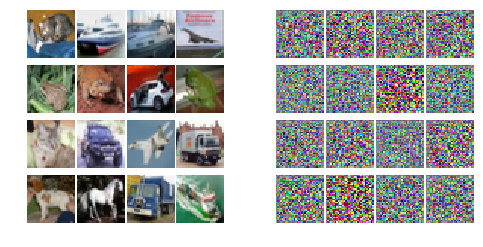

Epoch: 0, C: 1.379, D: 3.307, G:1.006


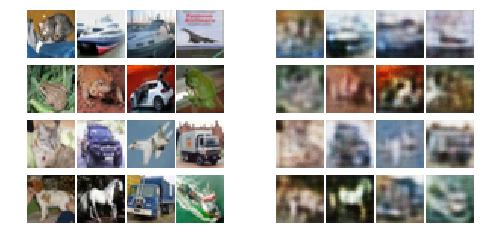

In [ ]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    train(dataset, sess, GAN, epoch, show_plot=False)